# AE Experimentation

## Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from copy import deepcopy as dc

from utilities import split_data_into_sequences, train_test_split, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from data_evaluation.predictive.TimeSeriesDataset import TimeSeriesDataset
from VAE import FCVAE, LSTMVAE, train_vae, ConvVAE

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

In [4]:
model_name = 'FCVAE'
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0004,
    "batch_size": 32,
    "num_epochs": 1000,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Data

In [5]:
traffic_df = pd.read_csv(REAL_DATA_FOLDER / "metro_interstate_traffic_volume_label_encoded_no_categorical.csv")
traffic_df.shape

(28511, 5)

In [6]:
traffic_np = traffic_df.to_numpy()
traffic_np.shape

(28511, 5)

### Preprocessing

In [7]:
# Train test split
train, test = train_test_split(traffic_np, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [8]:
# scale data
scaler = Scaler(train)
train_scaled = scaler.scale_data(train)
val_scaled = scaler.scale_data(val)
test_scaled = scaler.scale_data(test)

In [9]:
# split data into sequences
train_seq_scaled = split_data_into_sequences(train_scaled, hyperparameters['seq_len'], shuffle_data=False)
val_seq_scaled = split_data_into_sequences(val_scaled, hyperparameters['seq_len'], shuffle_data=False)
test_seq_scaled = split_data_into_sequences(test_scaled, hyperparameters['seq_len'], shuffle_data=False)

Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


In [10]:
# create datasets
# NOTE: The targets are not used in the training process, but are required by the PyTorch Dataset class
train_dataset = TimeSeriesDataset(train_seq_scaled, np.zeros((train_seq_scaled.shape[0], 1)))
val_dataset = TimeSeriesDataset(val_seq_scaled, np.zeros((val_seq_scaled.shape[0], 1)))
test_dataset = TimeSeriesDataset(test_seq_scaled, np.zeros((test_seq_scaled.shape[0], 1)))

In [11]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

In [12]:
X_train, y = next(iter(train_loader))

In [13]:
X_train.shape

torch.Size([32, 12, 5])

## Autoencoder

In [14]:
if model_name == 'ConvVAE':
    model = ConvVAE(verbose=False).to(hyperparameters['device'])
elif model_name == 'FCVAE':
    model = FCVAE().to(hyperparameters['device'])
elif model_name == 'LSTMVAE':
    model = LSTMVAE().to(hyperparameters['device'])

In [15]:
if False:
    test_sample = train_seq_scaled[:32]
    
    model.eval()
    with torch.inference_mode():
        pred = model(torch.tensor(test_sample, dtype=torch.float32).to(hyperparameters['device']))
        print(pred.shape)

## Training

In [16]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparameters['lr'])
criterion = nn.MSELoss()

In [17]:
train_vae(
    model=model,
    hyperparameters=hyperparameters,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    model_name=model_name
)

Epoch 1 | avg. Recon Loss: 0.0653 | avg. KL Loss: 2.5131 | avg. Train Loss: 0.0678 | avg. Val Loss: 0.0768
INFO: Validation loss did not improve in epoch 4
INFO: Validation loss did not improve in epoch 11
Epoch 11 | avg. Recon Loss: 0.0229 | avg. KL Loss: 4.4418 | avg. Train Loss: 0.0273 | avg. Val Loss: 0.0592
INFO: Validation loss did not improve in epoch 20
Epoch 21 | avg. Recon Loss: 0.0216 | avg. KL Loss: 4.6789 | avg. Train Loss: 0.0263 | avg. Val Loss: 0.0525
INFO: Validation loss did not improve in epoch 27
INFO: Validation loss did not improve in epoch 28
Epoch 31 | avg. Recon Loss: 0.0211 | avg. KL Loss: 4.7674 | avg. Train Loss: 0.0259 | avg. Val Loss: 0.0502
INFO: Validation loss did not improve in epoch 32
Epoch 41 | avg. Recon Loss: 0.0162 | avg. KL Loss: 4.9390 | avg. Train Loss: 0.0211 | avg. Val Loss: 0.0440
INFO: Validation loss did not improve in epoch 42
INFO: Validation loss did not improve in epoch 46
INFO: Validation loss did not improve in epoch 49
Epoch 51 | a

In [18]:
# load best model
if model_name == 'ConvVAE':
    test_model = ConvVAE(verbose=False).to(hyperparameters['device'])
elif model_name == 'FCVAE':
    test_model = FCVAE().to(hyperparameters['device'])
elif model_name == 'LSTMVAE':
    test_model = LSTMVAE().to(hyperparameters['device'])

test_model.load_state_dict(torch.load(f"{model_name}.pth"))

<All keys matched successfully>

torch.Size([5, 12, 5])


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_42202/2221396859.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_test_sample = torch.tensor(samples[random_indices], dtype=torch.float32)


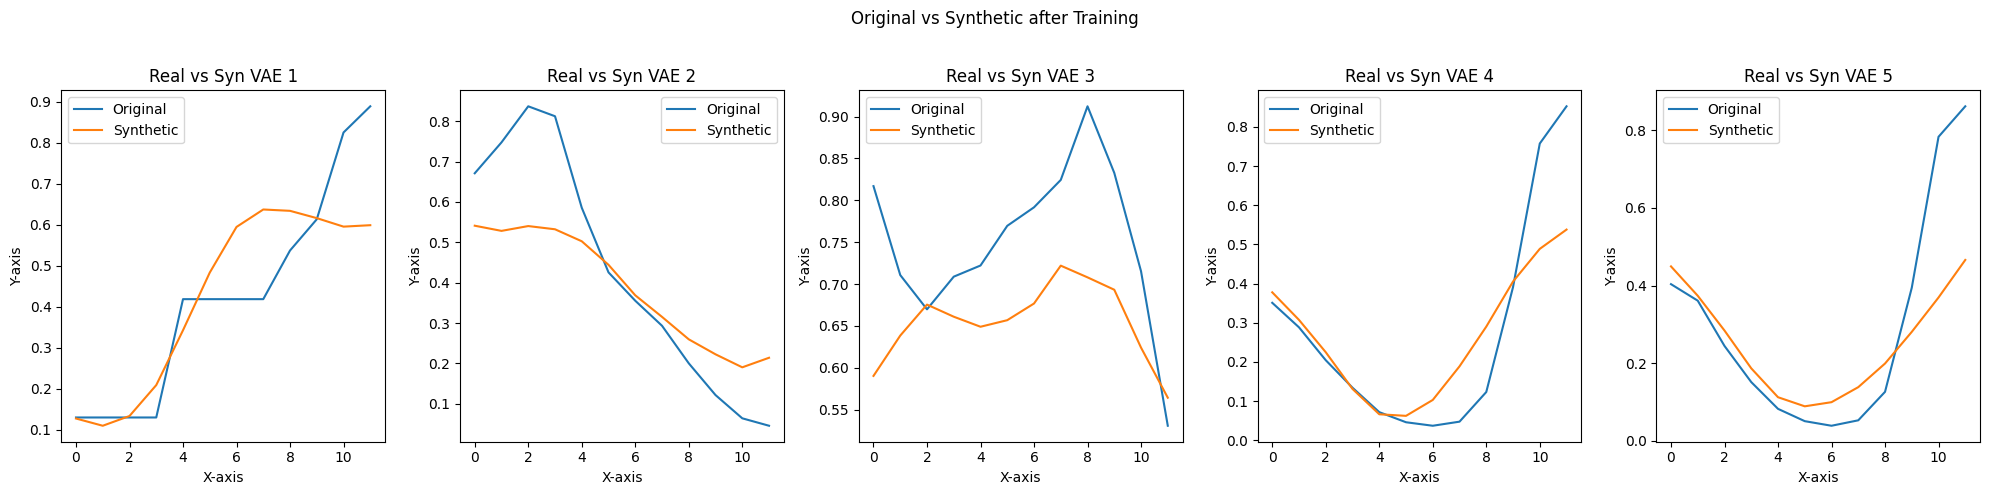

In [19]:
no_samples = 5
samples = next(iter(test_loader))[0]
random_indices = np.random.permutation(len(samples)-1)[:no_samples]
random_test_sample = torch.tensor(samples[random_indices], dtype=torch.float32)
random_test_sample = random_test_sample.float().to(hyperparameters['device'])

print(random_test_sample.shape)

test_model.eval()
with torch.inference_mode():
    _, _, test_pred = test_model(random_test_sample)
    # why is test_pred a tuple=

test_plot = dc(random_test_sample.detach().numpy())
pred_plot = dc(test_pred.detach().numpy())

# Erstellen Sie eine Figur und ein Array von Subplots
fig, axes = plt.subplots(1, no_samples, figsize=(20, 5))  # 1 Reihe, 5 Spalten

# Plotten Sie die Daten auf jedem Subplot
for i in range(no_samples):
    axes[i].plot(test_plot[i, :, 0], label='Original')
    axes[i].plot(pred_plot[i, :, 0], label='Synthetic')
    axes[i].legend()
    axes[i].set_title(f'Real vs Syn VAE {i+1}')
    axes[i].set_xlabel('X-axis')
    axes[i].set_ylabel('Y-axis')

# Setzen Sie einen Gesamt-Titel für die gesamte Figur
fig.suptitle('Original vs Synthetic after Training')

# Zeigen Sie die Plots an
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Platz für den Gesamt-Titel
plt.show()

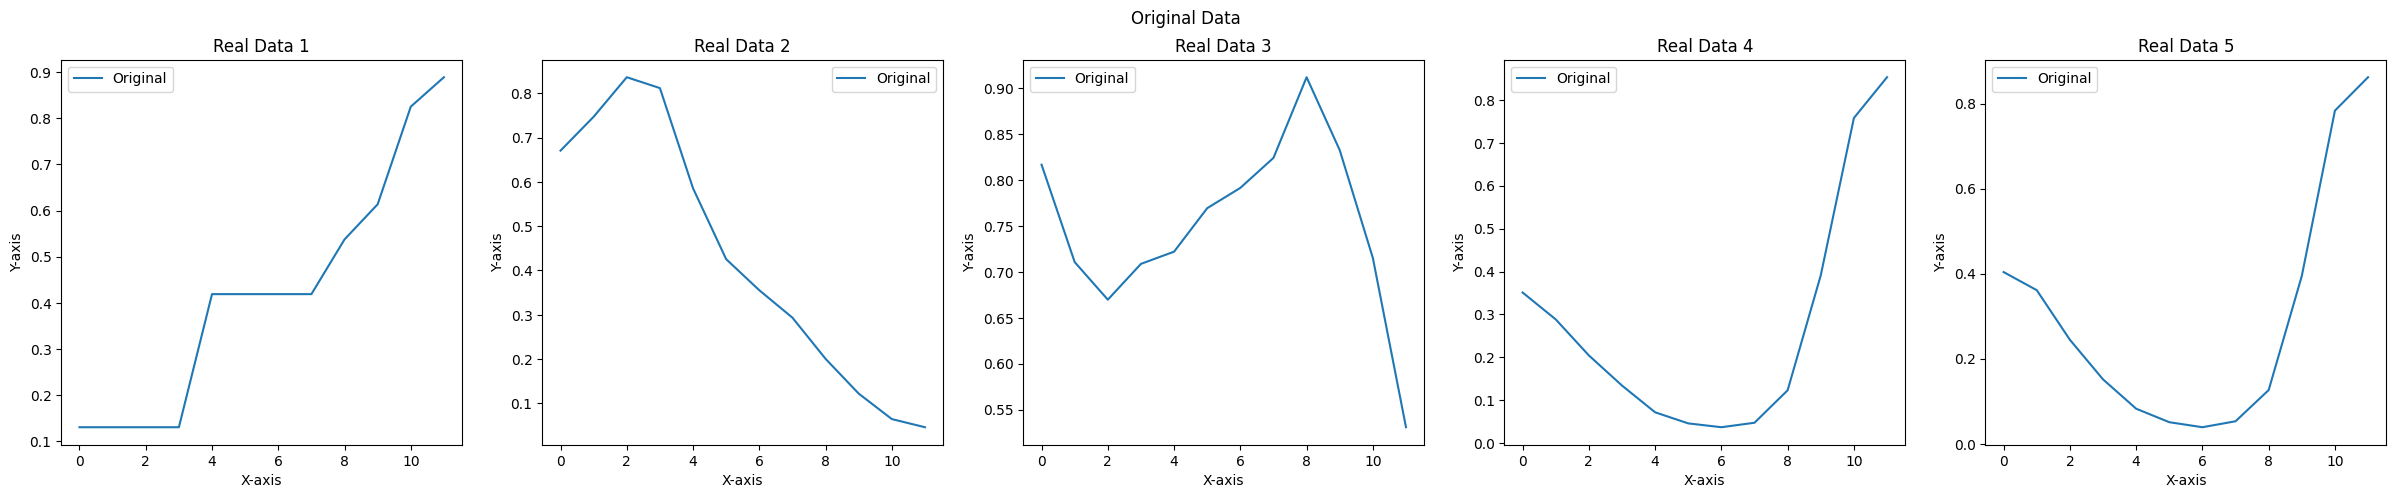

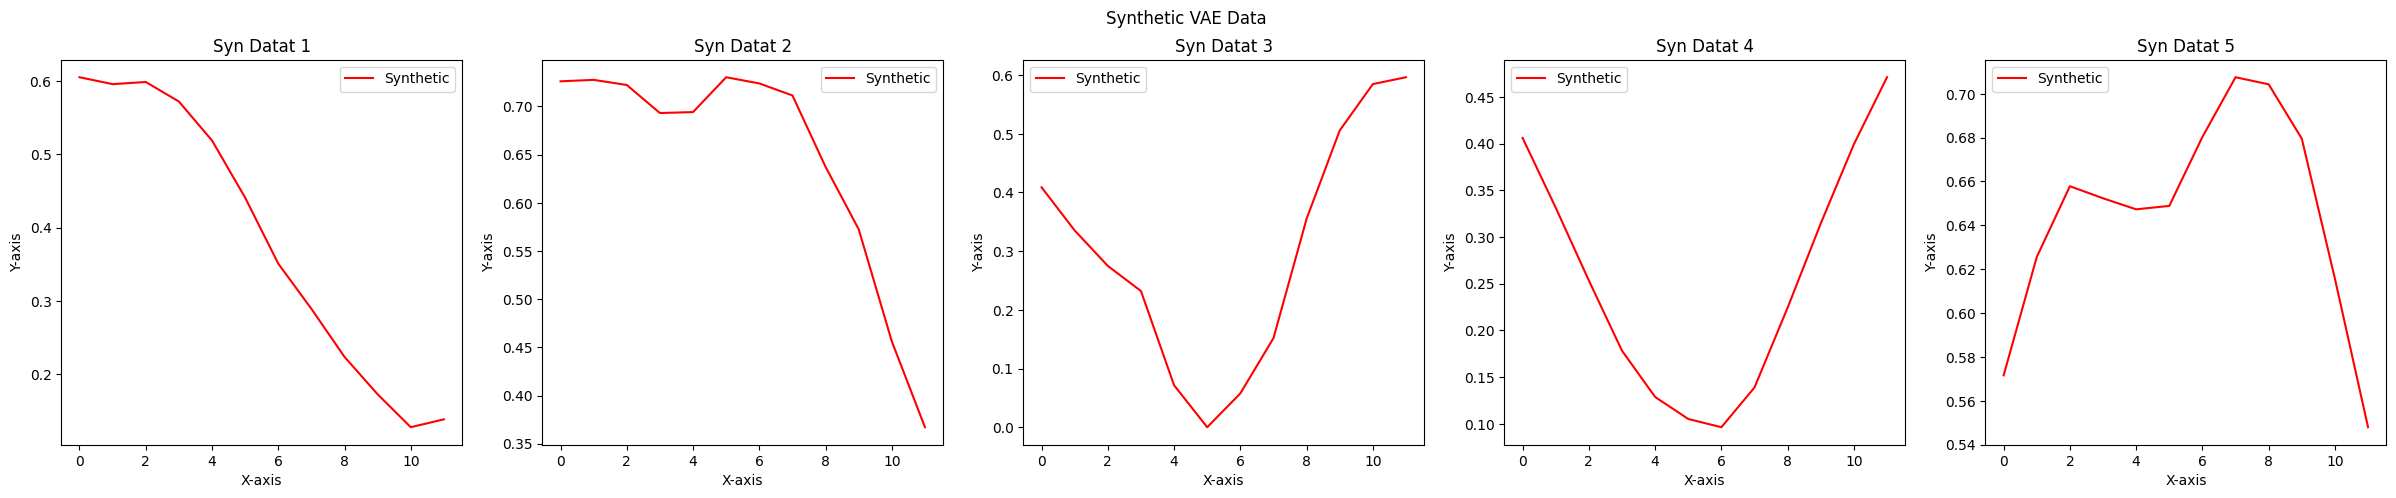

In [28]:
### get new data
z = torch.randn(no_samples, 4).to(hyperparameters['device'])
with torch.inference_mode():
    test_model.eval()
    new_samples = test_model.decode(z)


### Real Data Plot ###
fig, axes = plt.subplots(1, no_samples, figsize=(30, 5))  # 1 Reihe, 5 Spalten

for i in range(no_samples):
    axes[i].plot(test_plot[i, :, 0], label='Original')
    axes[i].legend()
    axes[i].set_title(f'Real Data {i+1}')
    axes[i].set_xlabel('X-axis')
    axes[i].set_ylabel('Y-axis')

fig.suptitle('Original Data')
plt.show()


### Synthetic data ###
fig, axes = plt.subplots(1, no_samples, figsize=(30, 5))  # 1 Reihe, 5 Spalten

for i in range(no_samples):
    axes[i].plot(new_samples[i, :, 0], label='Synthetic', color='red')
    axes[i].legend()
    axes[i].set_title(f'Syn Datat {i+1}')
    axes[i].set_xlabel('X-axis')
    axes[i].set_ylabel('Y-axis')

fig.suptitle('Synthetic VAE Data')
plt.show()

## Save Results

In [29]:
if True:
    z = torch.randn(traffic_np.shape[0], 4).to(hyperparameters['device'])
    with torch.inference_mode():
        test_model.eval()
        new_samples = test_model.decode(z)

    print(f'Shape of new samples: {new_samples.shape}')

    new_samples_scaled = scaler.inverse_scale_complete_dataset(new_samples.detach().numpy(), True)
    no, seq_len, dim = new_samples_scaled.shape
    data_to_save = new_samples_scaled.reshape(-1, new_samples_scaled.shape[1]*new_samples_scaled.shape[2])
    np.savetxt(f'vae_{no}_{seq_len}_{dim}.csv', data_to_save, delimiter=',')

Shape of new samples: torch.Size([28511, 12, 5])
